In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
from statannot import add_stat_annotation

# Montando DataFrames

## Features

In [2]:
df_features = pd.read_excel(os.path.join("TCGA_Run_2014_91cases_features_UChicago_V2010_MR_Workstation.xls"))
df_features.rename(columns={"Lesion Name": "Patients_id"}, inplace=True)
df_features["Patients_id"] = df_features.Patients_id.apply(lambda x: "-".join(x.split("-")[:3]))
df_features.set_index("Patients_id", inplace=True)
df_features.head()

,Maximum enhancement (K1),Time to peak (K2),Uptake rate (K3),Washout rate (K4),Curve shape index (K5),E1 (K6),Signal Enhancement Ratio (SER) (K7),Maximum enhancement-variance (E1),Enhancement-Variance Time to Peak (E2),Enhancement-variance Increasing Rate (E3),...,Irregularity (G2),Margin Sharpness (M1),Variance of Margin Sharpness (M2),Variance of Radial Gradient Histogram (vRGH) (M3),Size/Lesion volume (S1),Effective Diameter (S2),Surface Area (S3),Surface Area to Volume ratio (G3),Volume of most enhancing voxels (S4),Maximum Diameter (S5)
Patients_id,,,,,,,,,,,,,,,,,,,,,
TCGA-AO-A03M,1.602573,145.433,0.011019,0.000809,-0.099998,1.550204,1.111109,0.125963,60.000,0.002099,...,0.642163,0.188643,0.000143,0.014881,3139.6540,18.16747,2897.7040,0.922937,22.15705,27.60382
TCGA-AO-A03V,4.072152,144.752,0.028132,0.001510,-0.007311,3.973258,1.007365,4.054312,229.504,0.017666,...,0.452342,0.266607,0.000371,0.011217,1122.5800,12.89455,953.7904,0.849641,111.70860,21.31066
TCGA-AO-A0J9,1.303264,168.383,0.007740,0.000667,-0.146959,1.273733,1.172277,0.534411,60.000,0.008907,...,0.715572,0.269997,0.000323,0.005211,8211.5000,25.03079,6920.3380,0.842762,236.23630,41.33787
TCGA-AO-A0JI,0.758630,60.000,0.012644,0.000479,-0.150482,0.758630,1.177138,0.037956,298.418,0.000127,...,0.432493,0.179068,0.000407,0.020553,569.5309,10.28426,585.4972,1.028034,122.69640,11.39449
TCGA-AO-A0JM,3.353556,60.000,0.055893,0.000920,-0.080066,3.353556,1.087034,2.330160,60.000,0.038836,...,0.805132,0.314553,0.000409,0.004073,19709.4700,33.51394,18107.5700,0.918724,245.36130,68.62797


## Polak

In [3]:
df_polak = pd.read_table(os.path.join("summaryTableFig1.txt"))
df_polak = df_polak[["Unnamed: 0", "H2"]]
df_polak.columns = ["Patients_id", "H2"]
df_polak["Patients_id"] = df_polak.Patients_id.str.replace(".","-", regex=True)
df_polak.set_index("Patients_id", inplace=True)
df_polak.head()

,H2
Patients_id,
TCGA-D8-A1XK,285.150159
TCGA-A1-A0SO,262.990452
TCGA-D8-A1XQ,232.332479
TCGA-BH-A0BZ,220.479492
TCGA-A8-A08R,217.152082


## Imagens

In [23]:
imagens_id = os.listdir(os.path.join("Images","TCGA-BRCA"))[1:]
imagens_id = pd.Series(imagens_id, name="Patients_id")
imagens_id.to_csv("Patients_with_image.csv", index=False)

# Familias


In [5]:
class study_family():
    
    
    def __init__(self, family, HRD, HRP):
        global df_features, df_polak, imagens_id
        
        self.polak = df_polak.copy()
        self.features = df_features.copy()
        self.imagens_id = imagens_id
        
        self.family = family
        self.sup = HRD
        self.inf = HRP
        
        self.var_name="Radiomic Feature"
        self.value_name="Value"
        self.id_vars="H2"
        
        self.Q_sup = df_polak[self.id_vars].quantile(HRD)
        self.Q_inf = df_polak[self.id_vars].quantile(HRP)
        self.polak["Type"] = self.polak.H2.apply(self.quantile_func)
        self.polak["Availability"] = list(map(self.avail_func, self.polak.index))
        
        self.sample_feature = df_features.shape[0]
        self.sample_polak = df_polak.shape[0]
        self.sample_falatante =  set(df_features.index) - set(df_polak.index)
        
        
    def quantile_func(self, x):
        if x<self.Q_inf:
            return "HRP"
        elif x>self.Q_sup:
            return "HRD"
        else:
            return "Other"
    

    def avail_func(self, sample):
        if sample in set(self.features.index):
            return "Features"
        elif sample in set(self.imagens_id):
            return "Images"
        else:
            return "H2"
    
    
    def sep_family(self):
        regex = "\("+self.family+"\d"
        df_family = df_features.filter(axis=1, regex=regex).copy()
        self.features_name = [" ".join(feature.split(" ")[:-1]) for feature in df_family.columns]
        df_family.columns = self.features_name
        return df_family
    
    
    def get_df_merged(self):
        df_merged = pd.merge(left=self.polak.drop(columns=["H2", "Availability"]), right=self.sep_family(), 
                             left_index=True, right_index=True)
        self.sample = df_merged.shape[0]
        # df_merged.loc[:,self.id_vars] = df_merged[self.id_vars].apply(self.quantile_func)
        return df_merged
    
    
    def get_df_melted(self): 
        df_merged = self.get_df_merged()
        df_melted = df_merged.melt(id_vars= "Type", 
                                   var_name=self.var_name, value_name=self.value_name)
        return df_melted
    
    
    def plot_family(self, col_wrap=2):
        df_plot = self.get_df_melted()
        df_plot.drop(df_plot[df_plot["Type"] == "Other"].index, inplace=True)
        g = sns.catplot(df_plot, kind="box", 
                        x="Type", y=self.value_name, 
                        col=self.var_name, col_wrap=col_wrap,
                        sharey=False, aspect=1)
        
        titles = self.features_name

        for ax,title in zip(g.axes.flatten(),titles):
            ax.set_title(title )
        return g
    
       
    def get_df_pvalue(self, list_method=[stats.mannwhitneyu]):
        df_merged = self.get_df_merged()
        df_HRD = df_merged.loc[df_merged.Type == "HRD"].drop(columns="Type")
        df_HRP = df_merged.loc[df_merged.Type == "HRP"].drop(columns="Type")
        data = []
        for feature in self.features_name:
            for method in list_method:
                data.append([feature, method.__name__, method(df_HRD[feature], df_HRP[feature])[1]])
                
        df_pvalue = pd.DataFrame(data,columns=["Feature", "Method", "P_Value"])
        return df_pvalue
    

    def plot_local(self):
        fig, ax = plt.subplots(figsize= (10, 3))
        g = sns.scatterplot(self.polak.reset_index(), 
                        y="H2", x="Patients_id", hue="Type",
                        ax=ax, edgecolor="none", legend="full")
        g.set_xlabel("Samples")
        g.set_xticks([])
        g.set_xticklabels([])
        g.set_xlim((-1, self.polak.shape[0]))
        g.set_ylim((-1,250))
        return g
    
    
    def plot_proportion(self):
        g = sns.countplot(self.polak, 
                          x="Type", hue="Availability", dodge=False)
        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
        return g
    
    def get_important_feature(self, pvalue=.05):
        df_pvalue = self.get_df_pvalue()
        return df_pvalue.Feature[df_pvalue.P_Value <= pvalue].tolist()
    

Além disso, precisamos saber quais das ammostras de Polak temos as features de imagens, ou somente as imagens.


In [6]:
def color_sample(sample):
    global df_features, df_images
    if sample in set(df_features.index):
        return 0
    elif sample in set(imagens_id):
        return 1
    else:
        return 2

color_samples = np.array(list(map(color_sample, df_polak.index))).reshape(4,df_polak.shape[0]//4)


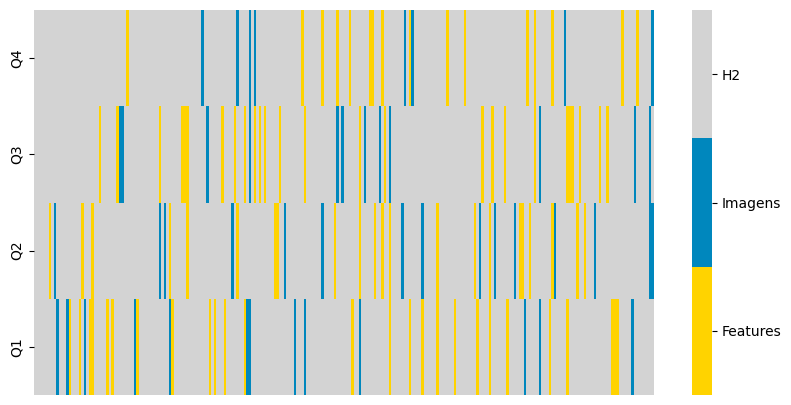

In [7]:
annot = df_polak.H2.to_numpy().reshape(4,df_polak.shape[0]//4)
fig, ax = plt.subplots(figsize=(10,5))
g = sns.heatmap(color_samples, cbar=True, cmap=['#FFD300', '#0087BD', 'lightgray'])
g.set_xticks([])
g.set_xticklabels([])
g.set_yticklabels("Q4 Q3 Q2 Q1".split(" "))
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([1/3, 1, 5/3])
colorbar.set_ticklabels(["Features", "Imagens", "H2"])

## Analise das features de cada familia

In [8]:
families = set(feature.split(" ")[-1][1] for feature in df_features.columns.tolist())
families

{'E', 'G', 'K', 'M', 'S', 'T'}

In [9]:
interval = (.75, .45)

none_family = study_family(None, *interval)

<AxesSubplot: xlabel='Samples', ylabel='H2'>

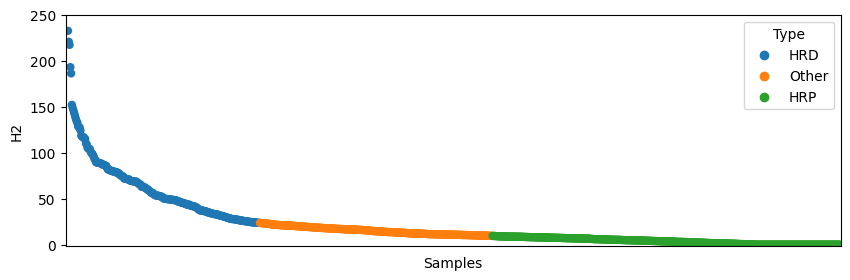

In [10]:
none_family.plot_local()

<AxesSubplot: xlabel='Type', ylabel='count'>

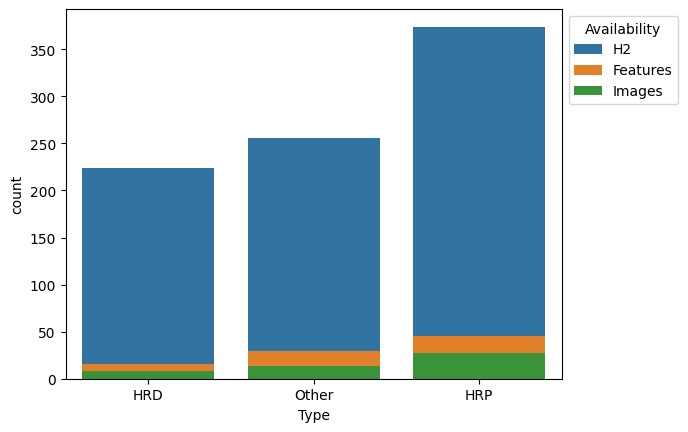

In [11]:
none_family.plot_proportion()

### Size

Note que, há uma relação bem destacada entre `Size/Lesion volume` e `Effective Diameter`, pois o que diferencia eles é apenas uma função. Esses foram os mais relevantes. Além disso

Junto com eles, vemos que `Surface Area` e`Maximum Diameter` trouce bastante relavanvia para diferenciar os tipos. Possivelmente a feature relacionado ao formato da lesão seja uma das features mais relevantes, porém as features são muito correlacionadas entre eleas.

- `Size/Lesion volume`: Volume of lesion
- `Effective Diameter`: Diameter of a sphere with the same volume as the lesion
- `Surface Area`: Lesion surface area
- `Maximum Diameter`: Maximum distance between any two voxels in the lesion

,Feature,Method,P_Value
0,Size/Lesion volume,mannwhitneyu,0.009814
1,Effective Diameter,mannwhitneyu,0.009814
2,Surface Area,mannwhitneyu,0.024171
3,Volume of most enhancing voxels,mannwhitneyu,0.407682
4,Maximum Diameter,mannwhitneyu,0.021246


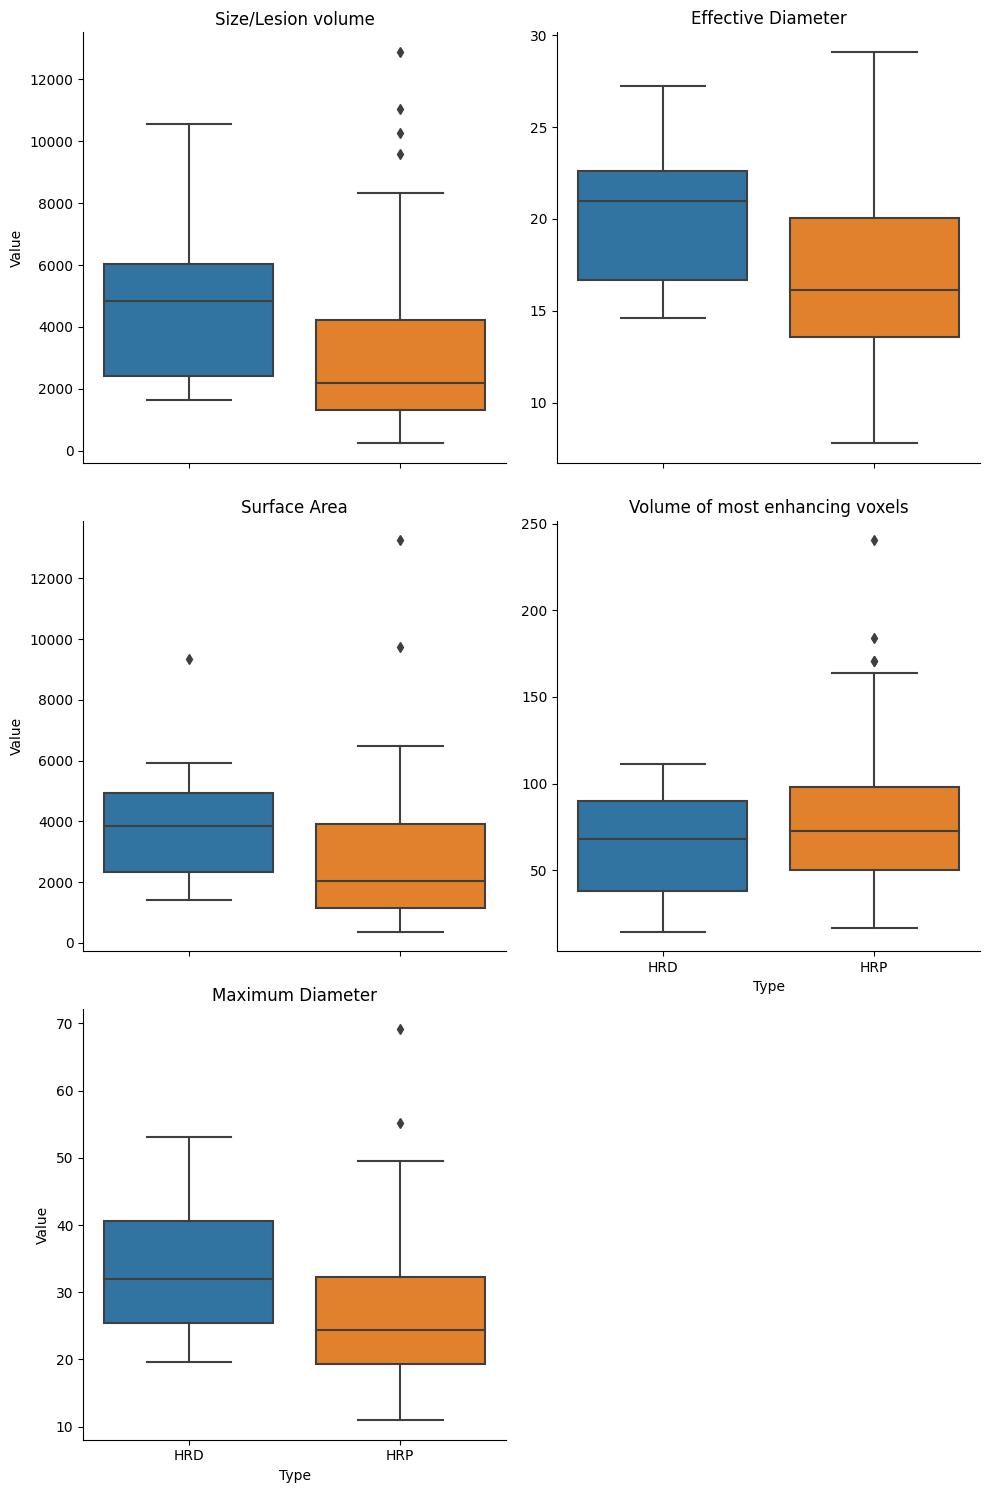

In [12]:
S = study_family("S", *interval)
S.plot_family(2)
display(S.get_df_pvalue())

### Morphology

`Variance of Radial Gradient Histogram (vRGH)` foi o que melhor se destacou.

- `Variance of Radial Gradient Histogram (vRGH)`: Degree to which the enhancement structure extends in a radial pattern originating from the center of the lesion.

! Encontrar algo explicando melhor essa feature.

,Feature,Method,P_Value
0,Margin Sharpness,mannwhitneyu,0.812085
1,Variance of Margin Sharpness,mannwhitneyu,0.290275
2,Variance of Radial Gradient Histogram (vRGH),mannwhitneyu,0.080787


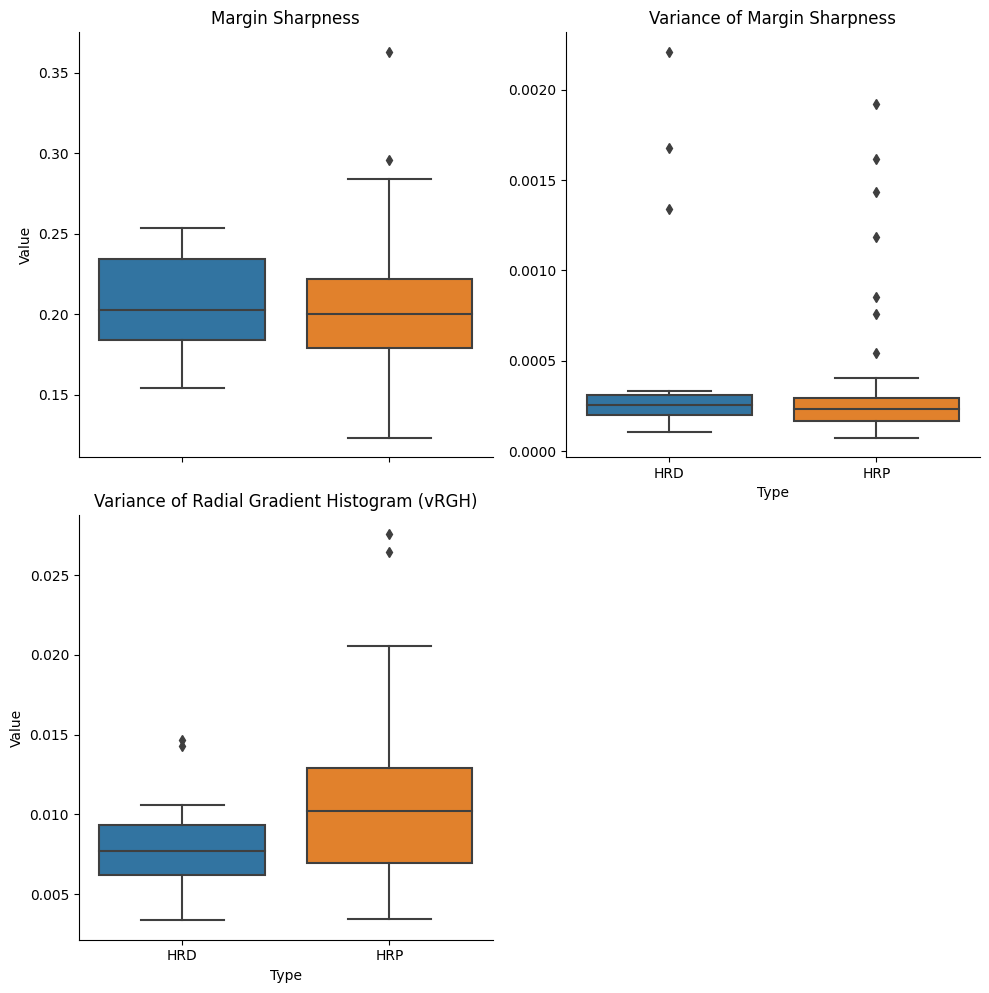

In [13]:
M = study_family("M", *interval)
M.plot_family(2)
display(M.get_df_pvalue())

### Kinetic Curve Assessment

- `Time to peak`: Time at which the maximum enhancement occurs;
- `Uptake rate`: Uptake speed of the contrast enhancement;
- `Curve shape index`: Difference between late and early enhancement.

,Feature,Method,P_Value
0,Maximum enhancement,mannwhitneyu,0.398459
1,Time to peak,mannwhitneyu,0.008359
2,Uptake rate,mannwhitneyu,0.018634
3,Washout rate,mannwhitneyu,0.407558
4,Curve shape index,mannwhitneyu,0.048192
5,E1,mannwhitneyu,0.290275
6,Signal Enhancement Ratio (SER),mannwhitneyu,0.048192


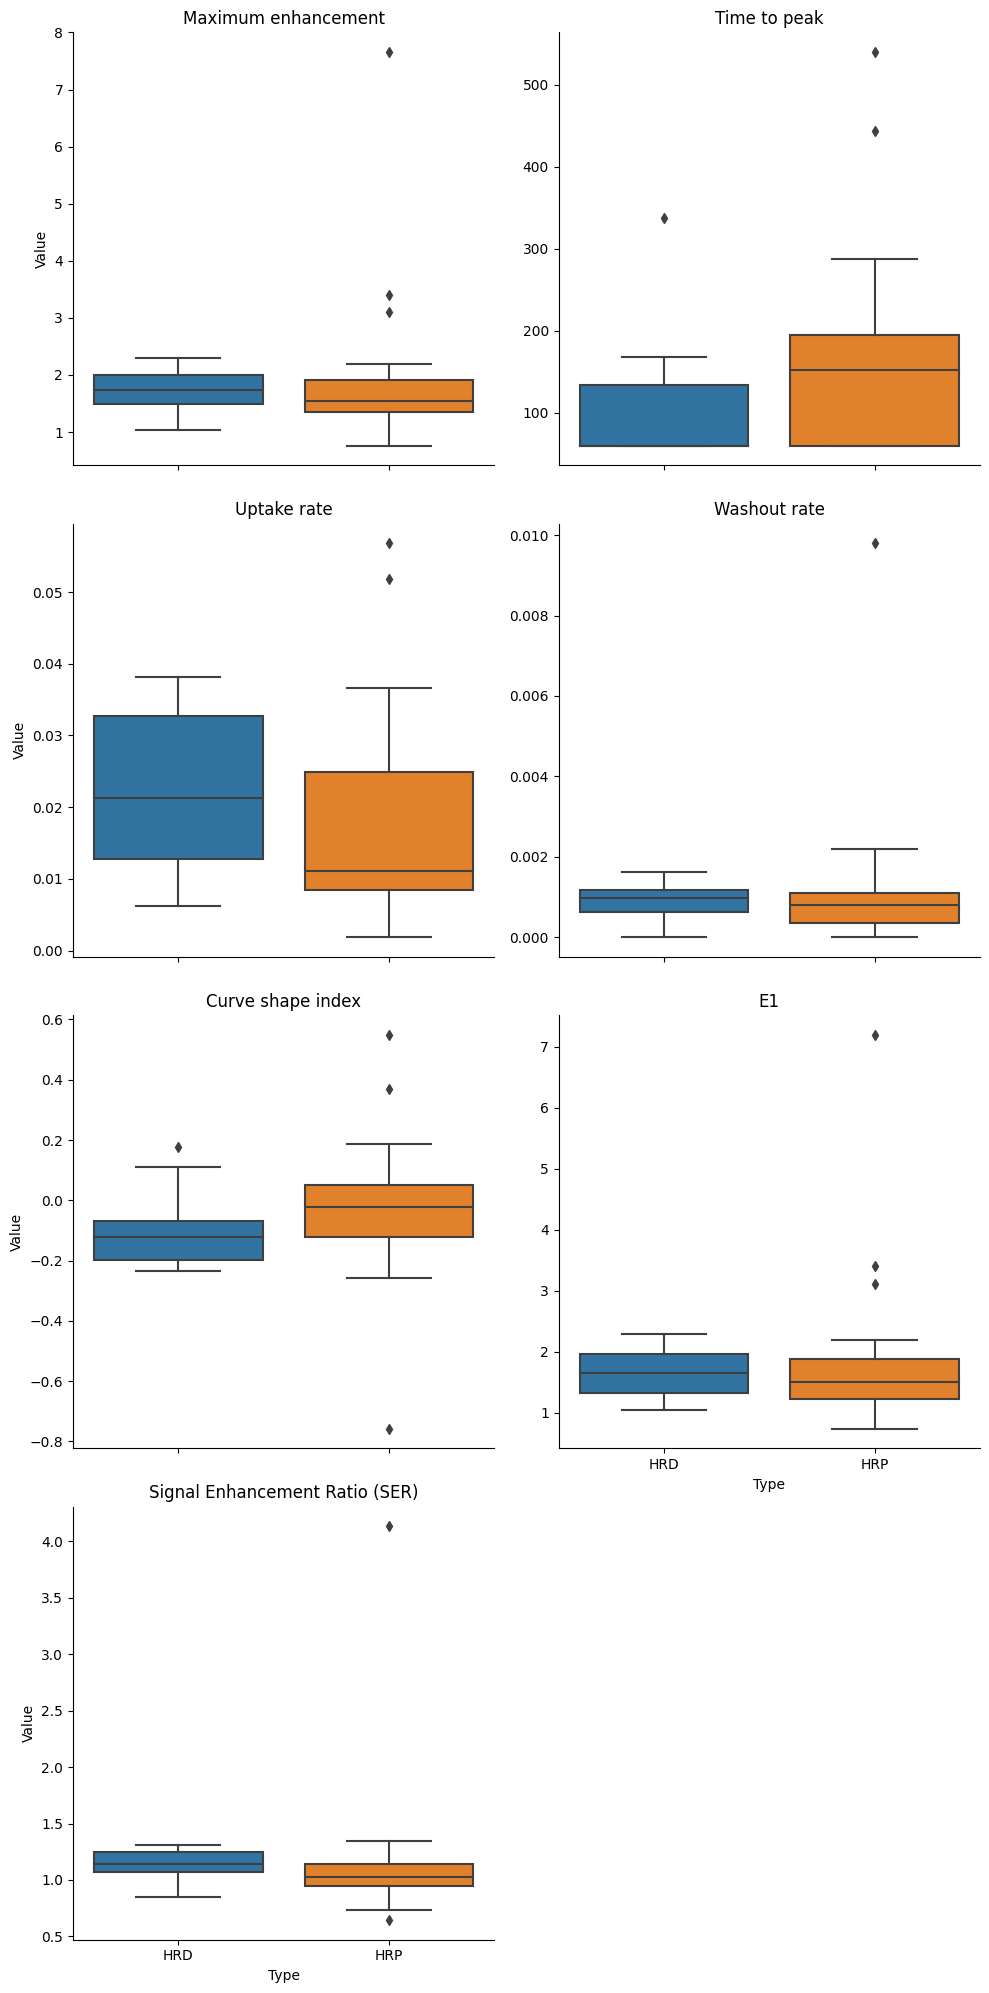

In [14]:
K = study_family("K", *interval)
K.plot_family(2)
display(K.get_df_pvalue())

### Shape

,Feature,Method,P_Value
0,Sphericity,mannwhitneyu,0.407682
1,Irregularity,mannwhitneyu,0.106317
2,Surface Area to Volume ratio,mannwhitneyu,0.297818


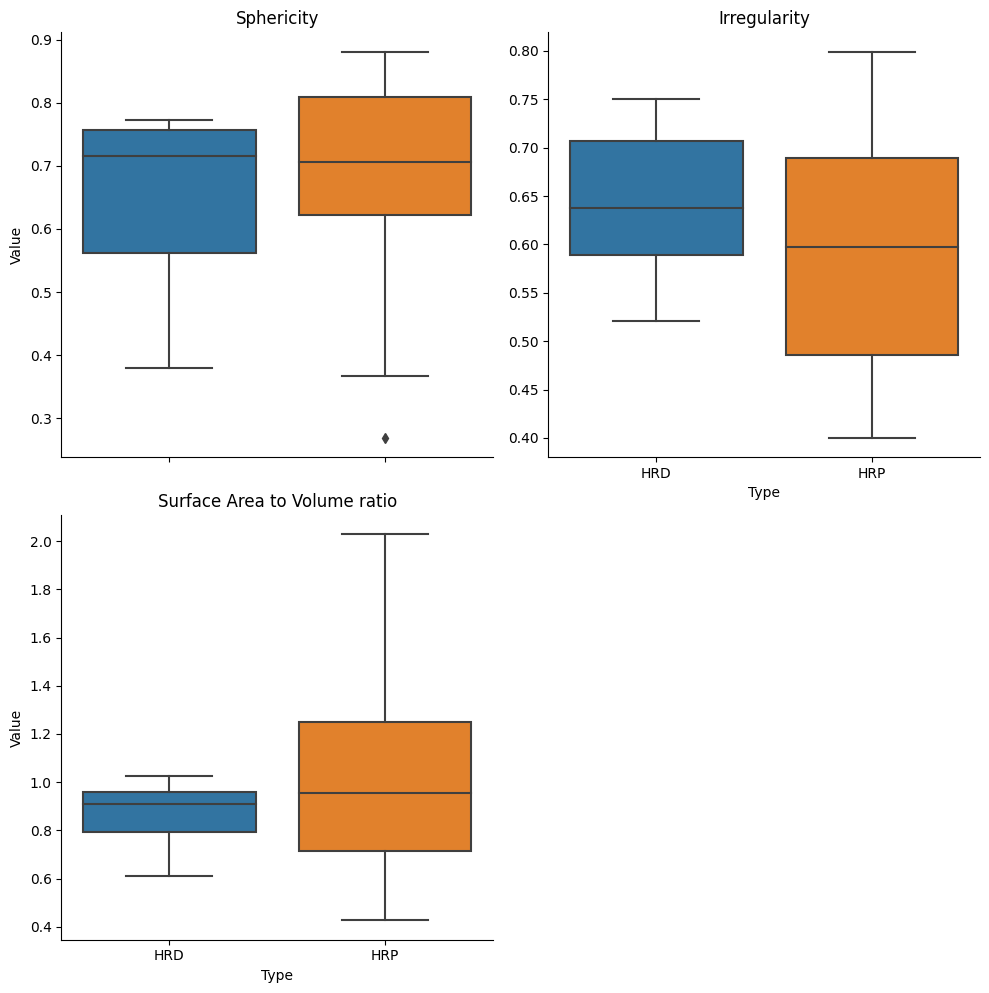

In [15]:
G = study_family("G", *interval)
G.plot_family(2)
display(G.get_df_pvalue())

### Enhancement Texture

- `Variance`: Spread in the gray-level distribution

,Feature,Method,P_Value
0,Contrast,mannwhitneyu,0.724459
1,Correlation,mannwhitneyu,0.837615
2,Difference Entropy,mannwhitneyu,0.582831
3,Difference Variance,mannwhitneyu,0.980379
4,Energy,mannwhitneyu,0.967305
5,Entropy,mannwhitneyu,0.928147
6,Homogeneity,mannwhitneyu,0.407682
7,IMC1,mannwhitneyu,0.876223
8,IMC2,mannwhitneyu,0.928147
9,Maximum Correlation Coefficient,mannwhitneyu,0.954239


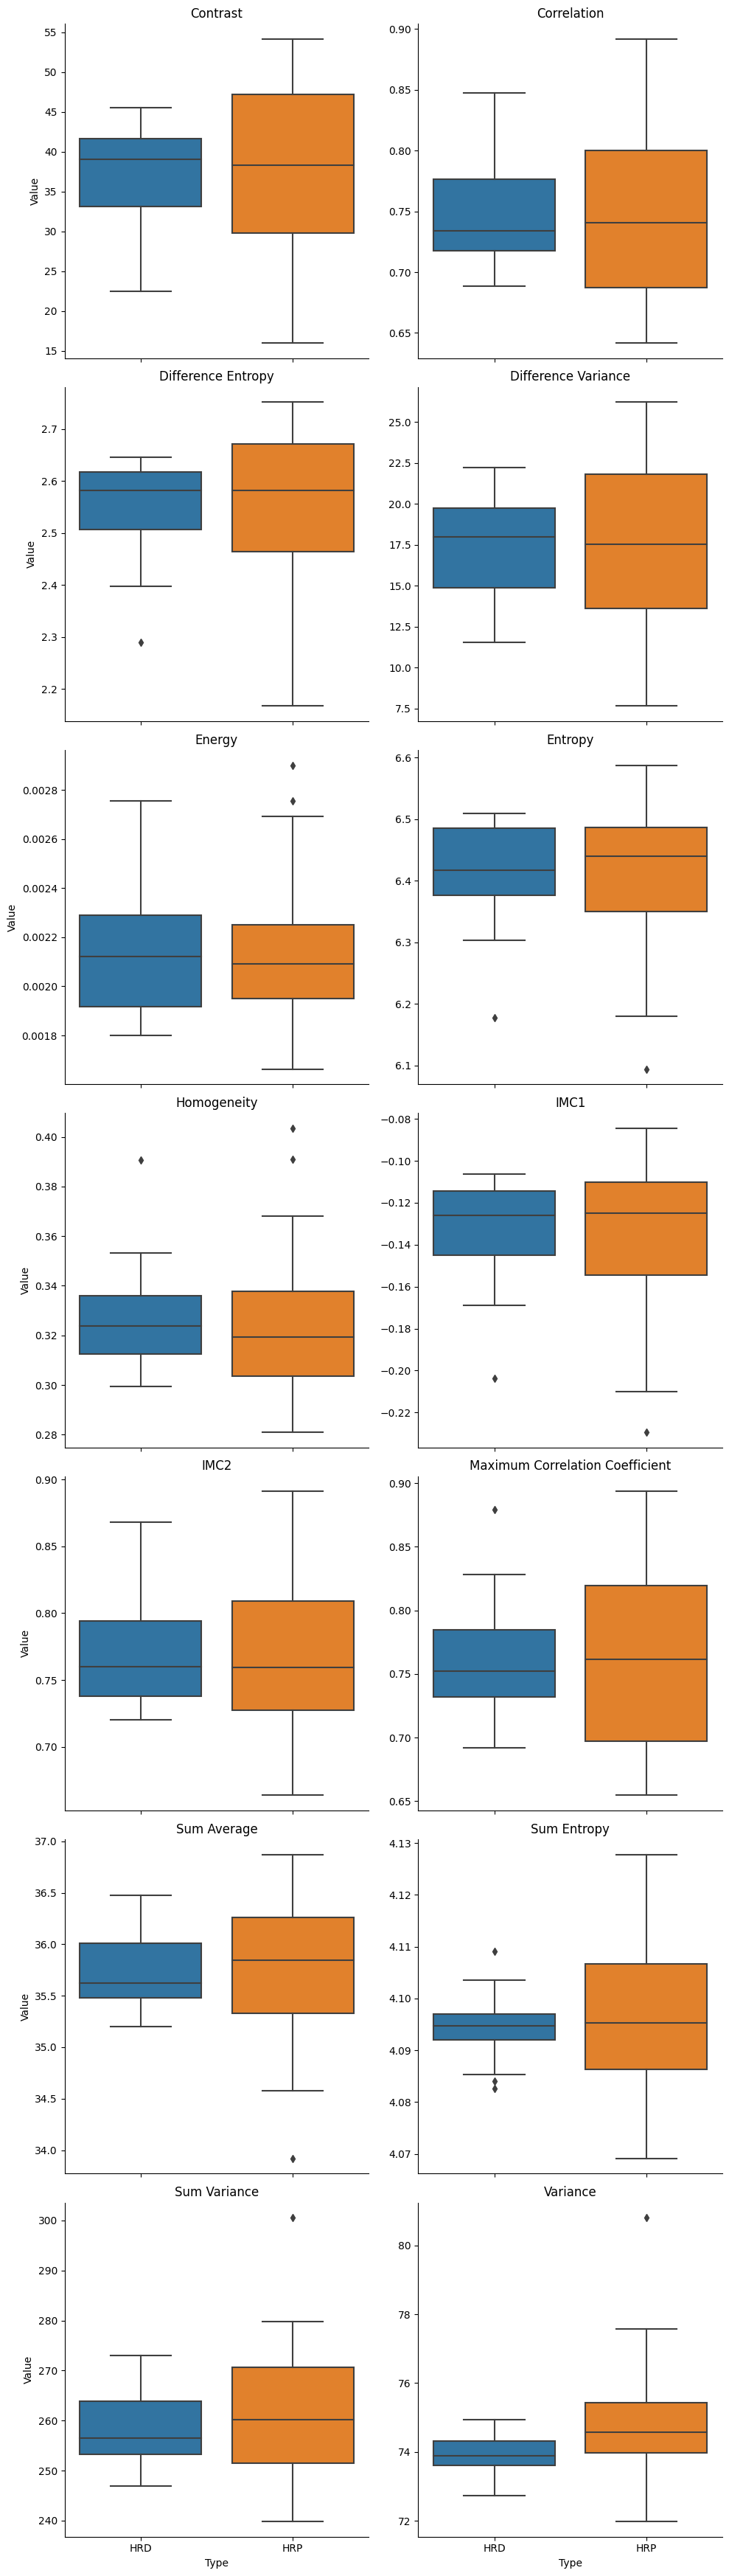

In [16]:
T = study_family("T", *interval)
T.plot_family(2)
display(T.get_df_pvalue())

### E

,Feature,Method,P_Value
0,Maximum enhancement-variance,mannwhitneyu,0.736787
1,Enhancement-Variance Time to Peak,mannwhitneyu,0.328334
2,Enhancement-variance Increasing Rate,mannwhitneyu,0.863316
3,Enhancement-variance Decreasing Rate,mannwhitneyu,0.341031


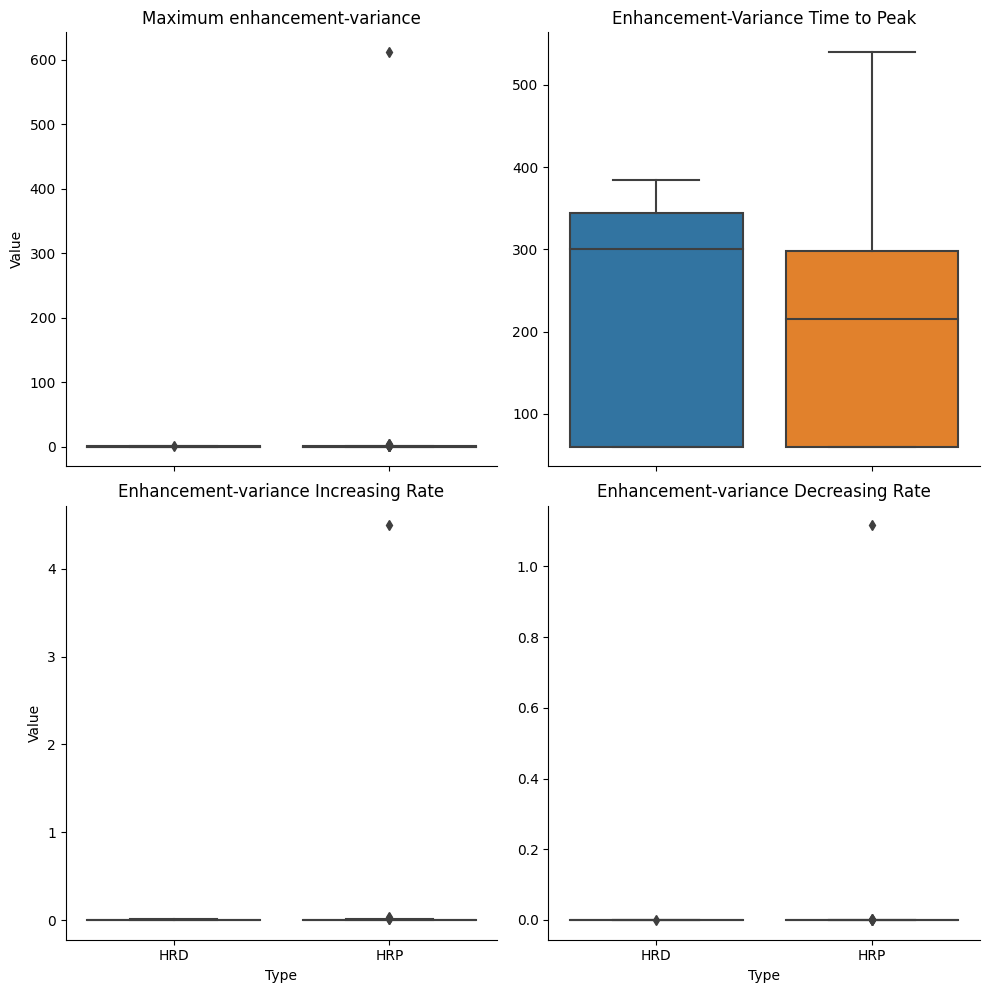

In [17]:
E = study_family("E", *interval)
E.plot_family(2)
display(E.get_df_pvalue())

## Avaliar features mais relevantes das familias juntas `E`, `G`, `K`, `M`, `S`, `T`

In [18]:
S.get_important_feature()

['Size/Lesion volume',
 'Effective Diameter',
 'Surface Area',
 'Maximum Diameter']

In [19]:
families = [E,G,K,M,S,T]
X = df_features.copy()
X.columns = [" ".join(feature.split(" ")[:-1]) for feature in X.columns]

important_features = []
for family in families:
    important_features += family.get_important_feature()
X = X[important_features]
y = none_family.polak.Type

[Text(0.5, 1.0, 'Correlação de Spearman')]

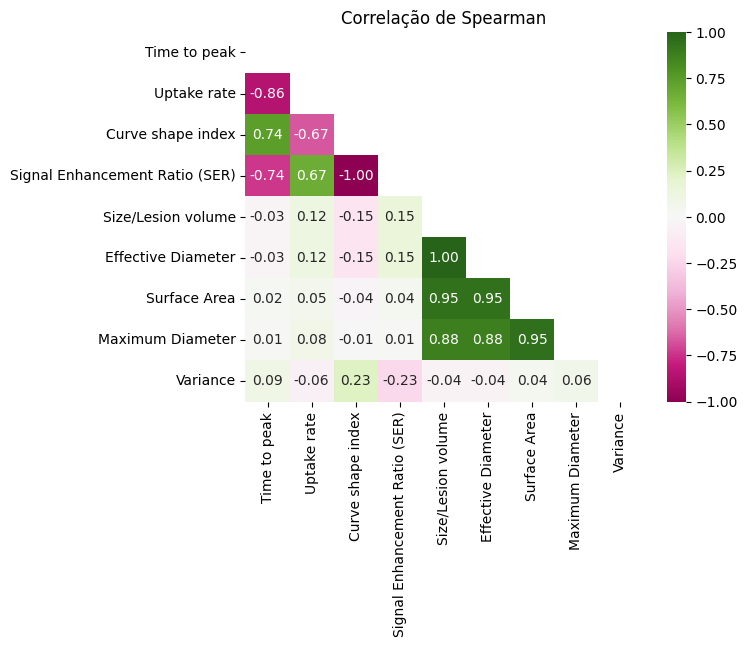

In [20]:
corr = X.corr("spearman")
sns.heatmap(corr, 
            annot=True, fmt=".2f",vmin=-1, cmap="PiYG",
            mask=np.triu(np.ones(corr.shape)).astype("bool")
           ).set(title="Correlação de Spearman")

Como o esperado `Size/Lesion volume` e `Effective Diameter` São analogas. Consideraremos, redundante features com correlação maior que $0.8$.

# Clusters

## Mostrar que é inviavel clusterizar as features

## Criar rotulos novos
atravez de dos dados de polak